In [1]:
!python --version

Python 3.7.16


In [1]:
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

In [2]:
envs = helpers.create_envs()
agents = helpers.create_agents(envs[0])

In [3]:
# a = helpers.train_no_comm(agents, envs, epochs = 20, batch_size = 20)

In [3]:
b, c = helpers.train_with_comm(agents, envs, epochs = 20, batch_size=20)

100%|████████████████████████████████████████████████████████████████████| 20/20 [08:51<00:00, 26.56s/it]


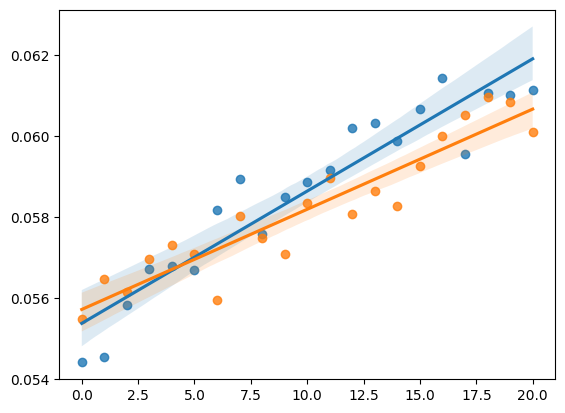

In [10]:
sns.regplot(x = np.arange(len(b)), y = b[:, 1])
sns.regplot(x = np.arange(len(b)), y = b[:, 0])
plt.show()

In [6]:
helpers.eval_agents_with_comm_deterministic(agents, envs[0])

array([0.06235599, 0.06755986])

In [8]:
envs[0].global_negotiation_state['proposals']

array([[[[[ True,  True,  True, ..., False, False,  True],
          [False,  True,  True, ..., False,  True,  True],
          [ True,  True,  True, ..., False,  True,  True],
          ...,
          [ True,  True,  True, ..., False,  True,  True],
          [False, False, False, ..., False, False, False],
          [ True,  True,  True, ...,  True,  True,  True]],

         [[ True,  True,  True, ..., False, False, False],
          [ True, False,  True, ..., False,  True, False],
          [ True,  True,  True, ..., False,  True, False],
          ...,
          [ True,  True, False, ...,  True, False, False],
          [False,  True,  True, ..., False,  True, False],
          [ True,  True, False, ..., False, False,  True]]],


        [[[ True,  True,  True, ..., False, False,  True],
          [False,  True,  True, ..., False,  True,  True],
          [ True,  True,  True, ..., False,  True,  True],
          ...,
          [ True,  True,  True, ..., False,  True,  True],
     